In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/c170m_final_project

/content/drive/MyDrive/c170m_final_project


In [3]:
import glob, os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load in filtered data
input_params = pd.read_csv("/content/drive/MyDrive/c170m_final_project/nn_input_params.csv")
cosmo_params = pd.read_csv("/content/drive/MyDrive/c170m_final_project/latin_hypercube_params.csv")

In [5]:
input_params = input_params.drop(["Unnamed: 0"], axis=1)
cosmo_params = cosmo_params.drop(["Unnamed: 0"], axis=1)

In [6]:
print(input_params.shape)
input_params.head()

(4284718, 4)


,index,ellipticity,radius,density_contrast
0,0.0,0.198568,129.17,3.487631
1,0.0,0.162464,172.36,3.154508
2,0.0,0.118820,83.54,2.724835
3,0.0,0.120590,75.79,2.692753
4,0.0,0.101951,64.01,2.678991


In [7]:
input_params[['ellipticity', 'radius', 'density_contrast']].describe()

,ellipticity,radius,density_contrast
count,4.284113e+06,4.284113e+06,4.284113e+06
mean,1.476931e-01,3.493021e+01,1.247533e+00
std,6.262249e-02,1.284644e+01,2.956997e-01
min,6.937000e-03,6.100000e+00,1.000000e+00
25%,1.070440e-01,2.579000e+01,1.068459e+00
50%,1.386900e-01,3.313000e+01,1.165414e+00
75%,1.775580e-01,4.184000e+01,1.335485e+00
max,9.985020e-01,6.021900e+02,2.198779e+02


In [8]:
# Find and drop NaNs in data
nan_df = input_params[input_params.isna().any(axis=1)]
drop_this_index = nan_df["index"].drop_duplicates().values[0]

cosmo_params = cosmo_params.drop(drop_this_index)

input_params = input_params.dropna()

In [9]:
cosmo_params = np.c_[cosmo_params.values]

In [10]:
om = np.c_[cosmo_params[:, 0]]
om.shape

(1999, 1)

In [119]:
s8 = np.c_[cosmo_params[:, 4]]
s8.shape

(1999, 1)

## Extract Ellipticity from Shapes Data

In [11]:
# Extract voids from each catalogue!
ellip_data = []
rad_data = []
dens_data = []

ellip_bins = [(i / 18) * 1 for i in range(0, 19)]
rad_bins = [(i / 18) * 650 for i in range(0, 19)]
dens_bins = [1 + (i / 18) * 2 for i in range(0, 19)]

for i in np.unique(input_params['index']):
  void_catalogue = input_params[input_params['index'] == i]

  ellipticity, radius, density_contrast = void_catalogue['ellipticity'].values, void_catalogue['radius'].values, void_catalogue['density_contrast'].values

# add later as a hyperparameter
  #norm_ellip = (ellipticity - np.mean(ellipticity)) / np.mean(ellipticity)
  #norm_rad = (radius - np.mean(radius)) / np.mean(radius)
  #norm_dens = (density_contrast - np.mean(density_contrast)) / np.mean(density_contrast)

  ellip_hist = np.histogram(ellipticity, bins=ellip_bins, range=(0,1))[0]
  rad_hist = np.histogram(radius, bins=rad_bins, range=(0,650))[0]
  dens_hist = np.histogram(density_contrast, bins=dens_bins, range=(1,3))[0] # maybe do 1 to 5?

  ellip_density = ellip_hist/ len(ellipticity)
  rad_density = rad_hist/ len(radius)
  dens_density = dens_hist/ len(density_contrast)

  ellip_data.append(ellip_density)
  rad_data.append(rad_density)
  dens_data.append(dens_density)

ellip_data = np.array(ellip_data)
rad_data = np.array(rad_data)
dens_data = np.array(dens_data)

In [12]:
big_data = np.hstack((ellip_data, rad_data, dens_data))

In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(big_data, cosmo_params, test_size=0.2, random_state=42)
ellip_train, ellip_test, om_train, om_test = train_test_split(ellip_data, om, test_size=0.2, random_state=42)
rad_train, rad_test, s8_train, s8_test = train_test_split(rad_data, s8, test_size=0.2, random_state=42)

In [121]:
ellip_train.shape, s8_train.shape

((1599, 18), (1599, 1))

## Extract Radius and Density Contrast from Centers Data

## Stack desired parameters into 2D array

In [15]:
# The model that we are going to select is a neural network using keras in tensorflow!!
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras import Model
from keras.optimizers import AdamW
from keras.models import Sequential
from tensorflow.math import log
from tensorflow.math import reduce_mean
from tensorflow.math import square
from tensorflow.math import reduce_sum

In [98]:
bs = 128

def custom_loss5(y_true, y_pred):
  y_nn = y_pred[:, 0:5]
  e_nn = y_pred[:, 5:]

  loss1 = reduce_mean(square(y_true - y_nn))
  loss2 = reduce_mean(square(square(y_true - y_nn) - square(e_nn)))
  loss = reduce_mean(log(loss1) + log(loss2))
  return loss

def custom_loss31(y_true, y_pred):
  y_nn = y_pred[:, 0]
  e_nn = y_pred[:, 1]

  loss1 = reduce_mean(square(y_true - y_nn))
  loss2 = reduce_mean(square(square(y_true - y_nn) - e_nn**2))
  loss = reduce_mean(log(loss1) + log(loss2))
  return loss

def custom_loss1(y_true, y_pred):
  y_nn = y_pred[:, 0]
  e_nn = y_pred[:, 1]

  loss1 = reduce_mean(square(y_true - y_nn))
  loss2 = reduce_mean(square(square(y_true - y_nn) - square(e_nn)))
  loss = reduce_mean(log(loss1) + log(loss2))

  train_loss1 += loss1 * bs
  train_loss2 += loss2 * bs
  points += bs
  i += 1
  train_loss = reduce_mean(log(train_loss1 / points) + log(train_loss2 / points))

  return train_loss

In [99]:
def create_model5():
    model = Sequential()

    model.add(Input(shape=(54,)))
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.2))

    for i in range(0, 3):
        model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(10, name='output'))

    adamw = AdamW(learning_rate=0.0002, weight_decay=0.0005)
    model.compile(loss=custom_loss5, optimizer=adamw)

    return model

def create_model31():
    model = Sequential()

    model.add(Input(shape=(54,)))
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.2))

    for i in range(0, 10):
        model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(1, name='output'))

    adamw = AdamW(learning_rate=0.0005, weight_decay=0.001)
    model.compile(loss='mean_squared_logarithmic_error', optimizer=adamw)

    return model

def create_model1():
    model = Sequential()

    model.add(Input(shape=(18,)))
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.2))

    for i in range(0, 3):
        model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(1, name='output'))

    adamw = AdamW(learning_rate=0.0005, weight_decay=0.001)
    model.compile(loss='mean_squared_logarithmic_error', optimizer=adamw)

    return model

In [100]:
all_model = create_model5()
all_model.summary()

model_31 = create_model31()
model_31.summary()

om_model = create_model1()
om_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 100)               5500      
                                                                 
 dense_41 (Dense)            (None, 100)               10100     
                                                                 
 dense_42 (Dense)            (None, 100)               10100     
                                                                 
 dense_43 (Dense)            (None, 100)               10100     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 36810 (143.79 KB)
Trainable params: 3681

In [101]:
all_model.fit(X_train, y_train, batch_size=bs, epochs=500)

Epoch 1/500
13/13 [==============================] - 2s 6ms/step - loss: -2.1539
Epoch 2/500
13/13 [==============================] - 0s 4ms/step - loss: -2.8131
Epoch 3/500
13/13 [==============================] - 0s 4ms/step - loss: -3.9011
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: -6.0456
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: -7.2131
Epoch 6/500
13/13 [==============================] - 0s 4ms/step - loss: -8.0852
Epoch 7/500
13/13 [==============================] - 0s 7ms/step - loss: -9.0095
Epoch 8/500
13/13 [==============================] - 0s 7ms/step - loss: -9.6486
Epoch 9/500
13/13 [==============================] - 0s 6ms/step - loss: -10.0706
Epoch 10/500
13/13 [==============================] - 0s 6ms/step - loss: -10.3199
Epoch 11/500
13/13 [==============================] - 0s 7ms/step - loss: -10.5874
Epoch 12/500
13/13 [==============================] - 0s 7ms/step - loss: -10.6228
Epoch 13/500
13/13 [=

In [122]:
model_31.fit(X_train, s8_train, batch_size=bs, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0255
Epoch 2/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0053
Epoch 3/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0047
Epoch 4/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.0041
Epoch 5/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0037
Epoch 6/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 7/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0030
Epoch 8/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.0031
Epoch 9/1000
13/13 [==============================] - 0s 15ms/step - loss: 0.0026
Epoch 10/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 11/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0024
Epoch 12/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0021
Epoch 13/1000

In [102]:
model_31.fit(X_train, om_train, batch_size=bs, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 3s 10ms/step - loss: 0.0364
Epoch 2/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 3/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 4/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0075
Epoch 5/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0069
Epoch 6/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0060
Epoch 7/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 8/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0048
Epoch 9/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0047
Epoch 10/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 11/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 12/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 13/1000
13/13 [

In [103]:
om_model.fit(ellip_train, om_train, batch_size=bs, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 1s 3ms/step - loss: 0.0301
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0083
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0077
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 13/1000
13/13 [====

In [104]:
# Generate predictions for the test set
predictions_all = all_model.predict(X_test)
predictions_31 = model_31.predict(X_test)
predictions_om = om_model.predict(ellip_test)

13/13 [==============================] - 0s 2ms/step


In [123]:
ps = model_31.predict(X_test)

13/13 [==============================] - 0s 2ms/step


In [105]:
print(y_test[1], predictions_all[6])
print(om_test[1], predictions_31[1])
print(om_test[1], predictions_om[1])

[0.3291  0.06573 0.5677  1.0689  0.8299 ] [0.32537585 0.0499119  0.6951641  1.0123565  0.78247684 0.06181114
 0.00201057 0.11368669 0.11019568 0.06452223]
[0.3291] [0.23963425]
[0.3291] [0.33800018]


In [106]:
predictions_all.shape

(400, 10)

In [107]:
for i in range(predictions_all.shape[0]):
  for j in range(predictions_all.shape[1]):
    if predictions_all[i, j] < 0:
      predictions_all[i, j] = - predictions_all[i, j]

In [108]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [124]:
from sys import ps1
# Assuming y_test and predictions are defined
mae_31 = mean_absolute_error(om_test, predictions_31[:, 0])
mse_31 = mean_squared_error(om_test, predictions_31[:, 0])
rmse_31 = np.sqrt(mse_31)
r2_31 = r2_score(om_test, predictions_31[:, 0])

print(f"\nMean Absolute Error (MAE): {mae_31}")
print(f"Mean Squared Error (MSE): {mse_31}")
print(f"Root Mean Squared Error (RMSE): {rmse_31}")
print(f"R-squared: {r2_31}")

mae_s = mean_absolute_error(s8_test, ps[:, 0])
mse_s = mean_squared_error(s8_test, ps[:, 0])
rmse_s = np.sqrt(mse_s)
r2_s = r2_score(s8_test, ps[:, 0])

print(f"\nMean Absolute Error (MAE): {mae_s}")
print(f"Mean Squared Error (MSE): {mse_s}")
print(f"Root Mean Squared Error (RMSE): {rmse_s}")
print(f"R-squared: {r2_s}")

mae_om = mean_absolute_error(om_test, predictions_om[:, 0])
mse_om = mean_squared_error(om_test, predictions_om[:, 0])
rmse_om = np.sqrt(mse_om)
r2_om = r2_score(om_test, predictions_om[:, 0])

print(f"\nMean Absolute Error (MAE): {mae_om}")
print(f"Mean Squared Error (MSE): {mse_om}")
print(f"Root Mean Squared Error (RMSE): {rmse_om}")
print(f"R-squared: {r2_om}")


Mean Absolute Error (MAE): 0.044399306073457004
Mean Squared Error (MSE): 0.003150780447473346
Root Mean Squared Error (RMSE): 0.056131813149704564
R-squared: 0.7533823901162829

Mean Absolute Error (MAE): 0.04380365339136124
Mean Squared Error (MSE): 0.0033125731859126595
Root Mean Squared Error (RMSE): 0.05755495796117533
R-squared: 0.7563949609207877

Mean Absolute Error (MAE): 0.0504159912738204
Mean Squared Error (MSE): 0.004022007752486929
Root Mean Squared Error (RMSE): 0.06341930110374072
R-squared: 0.6851897631751767


In [110]:
mae_all = mean_absolute_error(y_test, predictions_all[:, 0:5])
mse_all = mean_squared_error(y_test, predictions_all[:, 0:5])
rmse_all = np.sqrt(mse_all)
r2_all = r2_score(y_test, predictions_all[:, 0:5])

print(f"Mean Absolute Error (MAE): {mae_all}")
print(f"Mean Squared Error (MSE): {mse_all}")
print(f"Root Mean Squared Error (RMSE): {rmse_all}")
print(f"R-squared: {r2_all}")

mae_0 = mean_absolute_error(y_test[:, 0], predictions_all[:, 0])
mse_0 = mean_squared_error(y_test[:, 0], predictions_all[:, 0])
rmse_0 = np.sqrt(mse_0)
r2_0 = r2_score(y_test[:, 0], predictions_all[:, 0])

print(f"\nMean Absolute Error (MAE): {mae_0}")
print(f"Mean Squared Error (MSE): {mse_0}")
print(f"Root Mean Squared Error (RMSE): {rmse_0}")
print(f"R-squared: {r2_0}")

mae_1 = mean_absolute_error(y_test[:, 1], predictions_all[:, 1])
mse_1 = mean_squared_error(y_test[:, 1], predictions_all[:, 1])
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_test[:, 1], predictions_all[:, 1])

print(f"\nMean Absolute Error (MAE): {mae_1}")
print(f"Mean Squared Error (MSE): {mse_1}")
print(f"Root Mean Squared Error (RMSE): {rmse_1}")
print(f"R-squared: {r2_1}")

mae_2 = mean_absolute_error(y_test[:, 2], predictions_all[:, 2])
mse_2 = mean_squared_error(y_test[:, 2], predictions_all[:, 2])
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_test[:, 2], predictions_all[:, 2])

print(f"\nMean Absolute Error (MAE): {mae_2}")
print(f"Mean Squared Error (MSE): {mse_2}")
print(f"Root Mean Squared Error (RMSE): {rmse_2}")
print(f"R-squared: {r2_2}")

mae_3 = mean_absolute_error(y_test[:, 3], predictions_all[:, 3])
mse_3 = mean_squared_error(y_test[:, 3], predictions_all[:, 3])
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test[:, 3], predictions_all[:, 3])

print(f"\nMean Absolute Error (MAE): {mae_3}")
print(f"Mean Squared Error (MSE): {mse_3}")
print(f"Root Mean Squared Error (RMSE): {rmse_3}")
print(f"R-squared: {r2_3}")

mae_4 = mean_absolute_error(y_test[:, 4], predictions_all[:, 4])
mse_4 = mean_squared_error(y_test[:, 4], predictions_all[:, 4])
rmse_4 = np.sqrt(mse_4)
r2_4 = r2_score(y_test[:, 4], predictions_all[:, 4])

print(f"\nMean Absolute Error (MAE): {mae_4}")
print(f"Mean Squared Error (MSE): {mse_4}")
print(f"Root Mean Squared Error (RMSE): {rmse_4}")
print(f"R-squared: {r2_4}")

Mean Absolute Error (MAE): 0.055632622793014654
Mean Squared Error (MSE): 0.005839941633887822
Root Mean Squared Error (RMSE): 0.07641951081947478
R-squared: 0.36380904829731386

Mean Absolute Error (MAE): 0.045363874944865705
Mean Squared Error (MSE): 0.003088709533744538
Root Mean Squared Error (RMSE): 0.0555761597606792
R-squared: 0.7582407992127886

Mean Absolute Error (MAE): 0.009818877230504154
Mean Squared Error (MSE): 0.00013115766513456404
Root Mean Squared Error (RMSE): 0.011452408704485011
R-squared: -0.0035990084827539626

Mean Absolute Error (MAE): 0.09638512388396263
Mean Squared Error (MSE): 0.013020604047104756
Root Mean Squared Error (RMSE): 0.11410786146057052
R-squared: 0.014303066923555985

Mean Absolute Error (MAE): 0.08203040184974669
Mean Squared Error (MSE): 0.009711717385530071
Root Mean Squared Error (RMSE): 0.09854804607667303
R-squared: 0.28892140892341933

Mean Absolute Error (MAE): 0.04456483605599403
Mean Squared Error (MSE): 0.003247519537925179
Root Mea

Text(0.5, 1.0, 'Actual vs. Predicted Values: Omega_m')

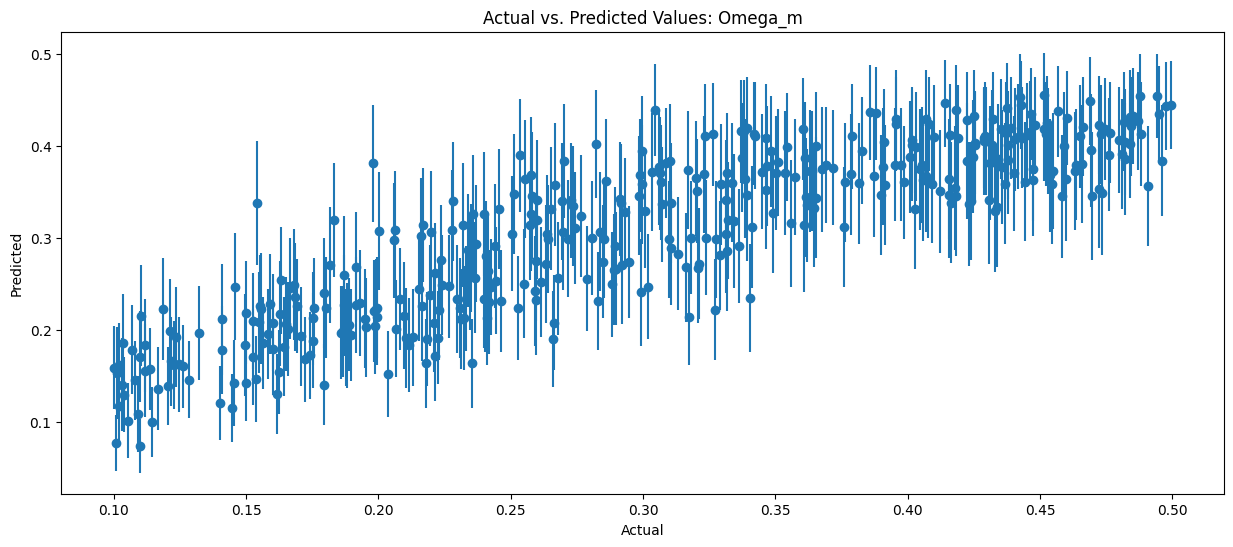

In [128]:
plt.figure(figsize=(15,6))

plt.scatter(y_test[:, 0], predictions_all[:, 0], zorder = 10)
plt.errorbar(y_test[:, 0], predictions_all[:, 0], yerr=predictions_all[:, 5], ls='none', zorder = 0)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values: Omega_m')

Text(0.5, 1.0, 'Actual vs. Predicted Values: Omega_b')

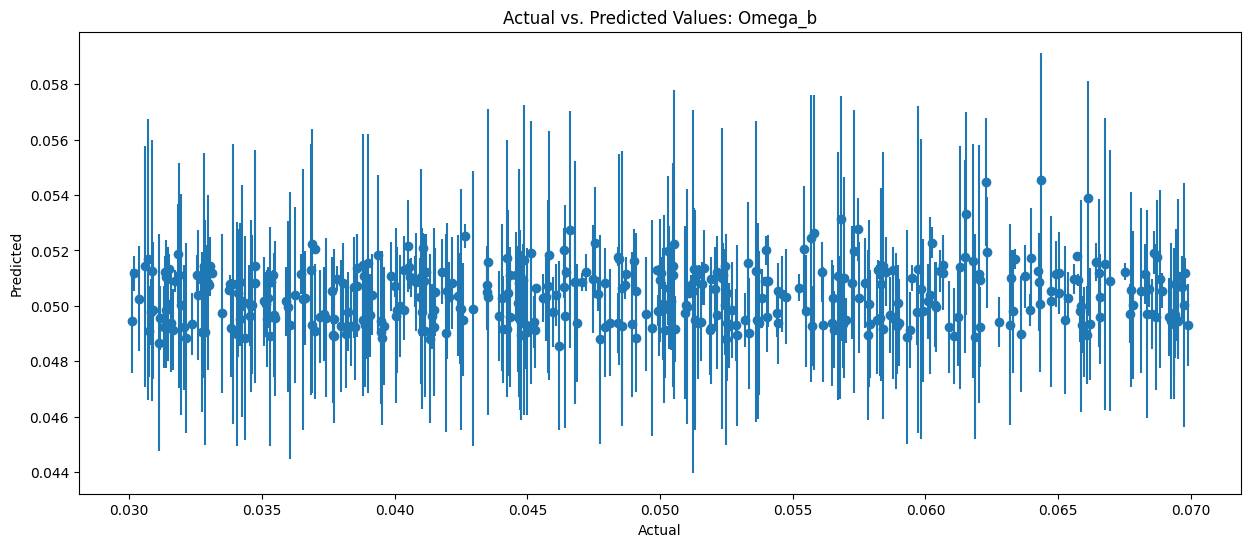

In [129]:
plt.figure(figsize=(15,6))

plt.scatter(y_test[:, 1], predictions_all[:, 1], zorder = 10)
plt.errorbar(y_test[:, 1], predictions_all[:, 1], yerr=predictions_all[:, 6], ls='none', zorder = 0)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values: Omega_b')

Text(0.5, 1.0, 'Actual vs. Predicted Values: h')

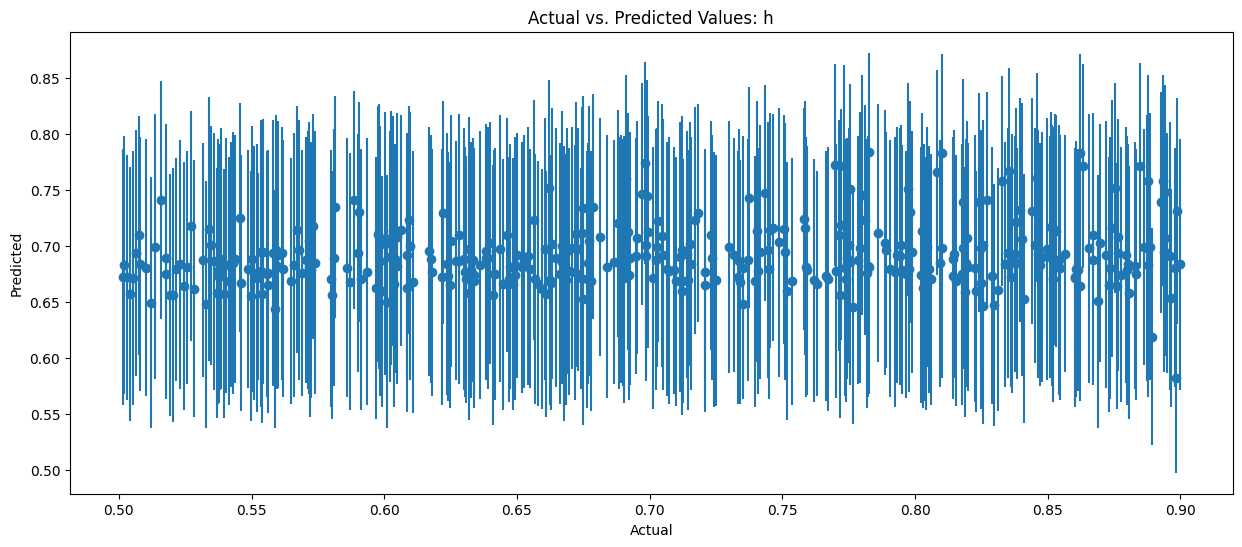

In [113]:
plt.figure(figsize=(15,6))

plt.scatter(y_test[:, 2], predictions_all[:, 2], zorder = 10)
plt.errorbar(y_test[:, 2], predictions_all[:, 2], yerr=predictions_all[:, 7], ls='none', zorder = 0)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values: h')

Text(0.5, 1.0, 'Actual vs. Predicted Values: n_s')

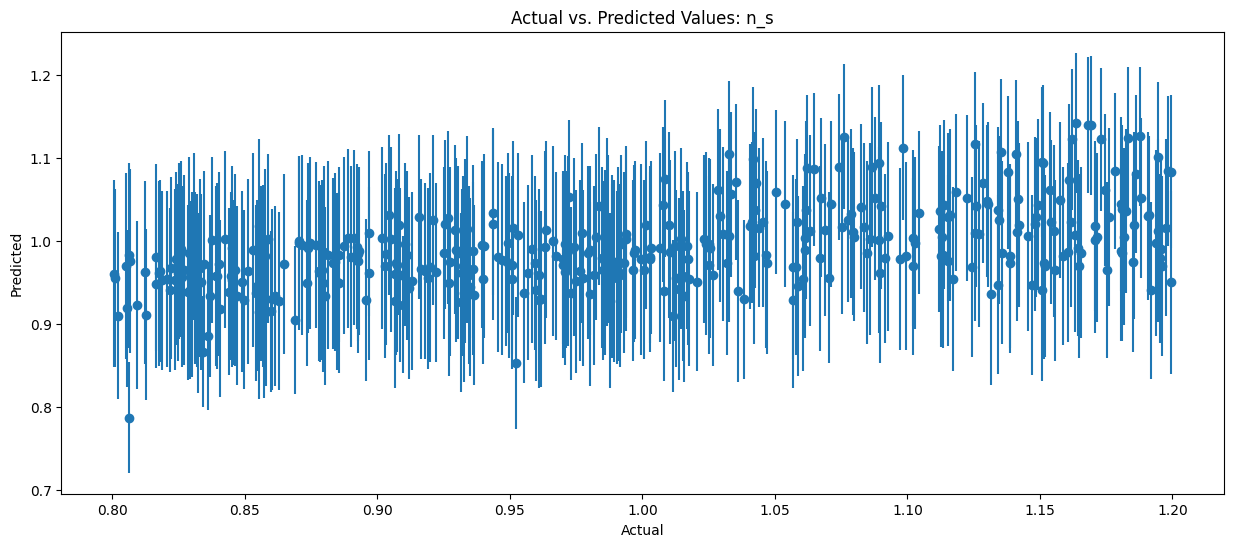

In [114]:
plt.figure(figsize=(15,6))

plt.scatter(y_test[:, 3], predictions_all[:, 3], zorder = 10)
plt.errorbar(y_test[:, 3], predictions_all[:, 3], yerr=predictions_all[:, 8], ls='none', zorder = 0)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values: n_s')

Text(0.5, 1.0, 'Actual vs. Predicted Values: sigma_8')

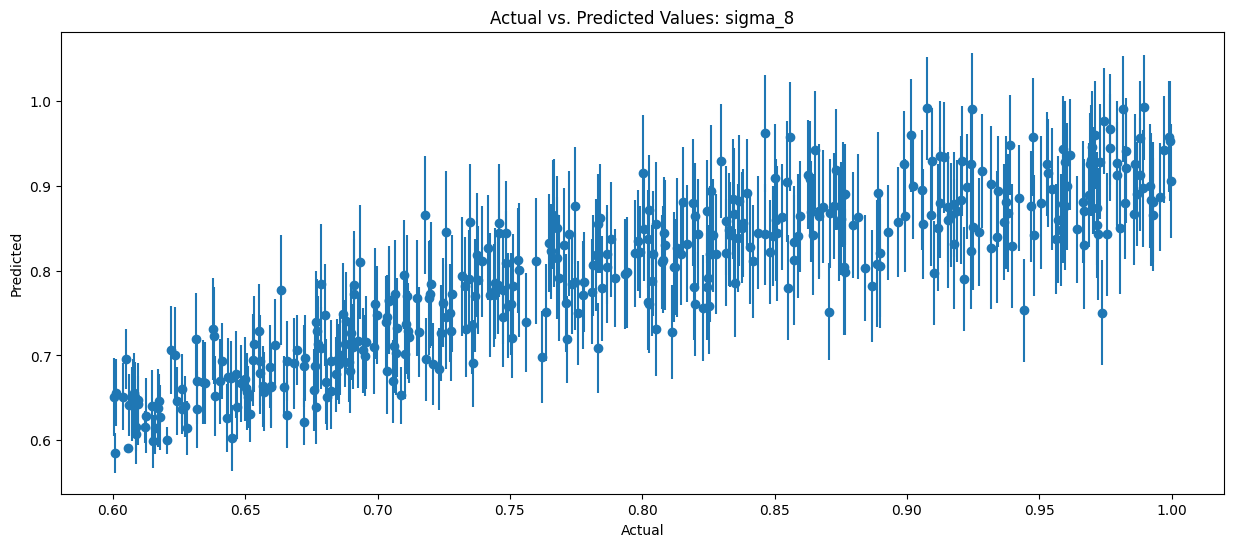

In [115]:
plt.figure(figsize=(15,6))

plt.scatter(y_test[:, 4], predictions_all[:, 4], zorder = 10)
plt.errorbar(y_test[:, 4], predictions_all[:, 4], yerr=predictions_all[:, 9], ls='none', zorder = 0)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values: sigma_8')

Text(0.5, 1.0, 'Actual vs. Predicted Values: 3 Void Parameters to Omega_m')

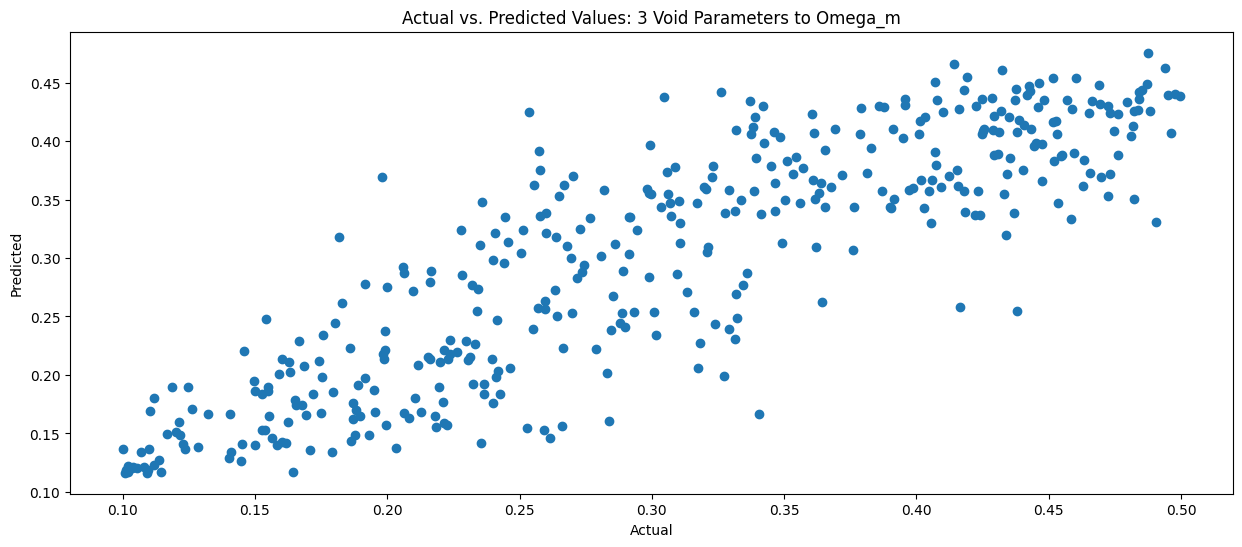

In [125]:
plt.figure(figsize=(15,6))

plt.scatter(om_test, predictions_31, zorder = 10)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values: 3 Void Parameters to Omega_m')

Text(0.5, 1.0, 'Actual vs. Predicted Values: 3 Void Parameters to Sigma_8')

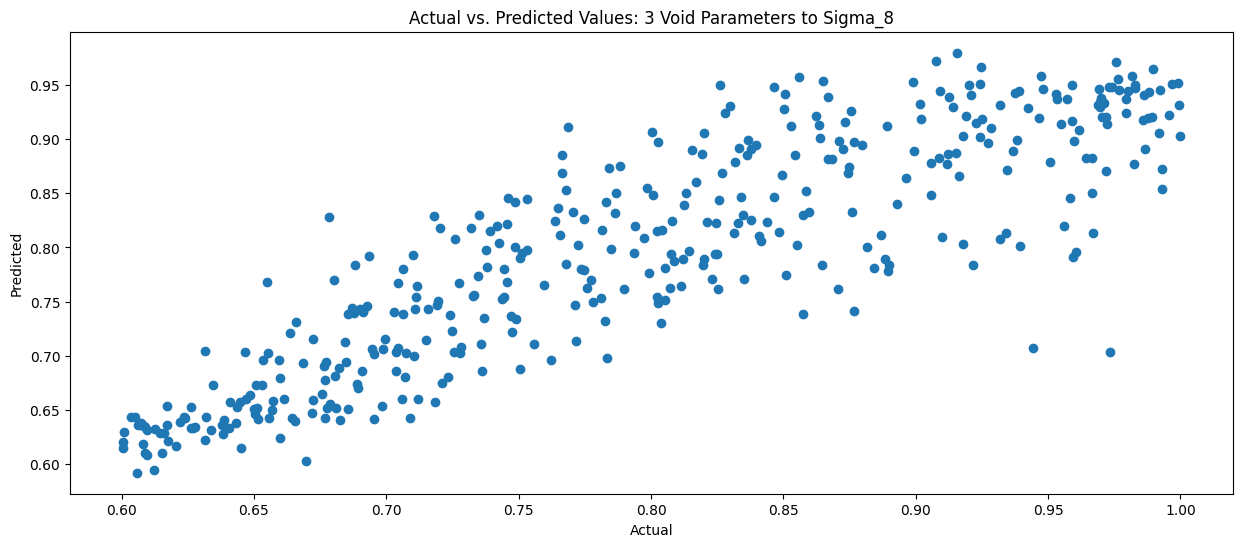

In [126]:
plt.figure(figsize=(15,6))

plt.scatter(s8_test, ps, zorder = 10)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values: 3 Void Parameters to Sigma_8')

Text(0.5, 1.0, 'Actual vs. Predicted Values: Ellipticity to Omega_m')

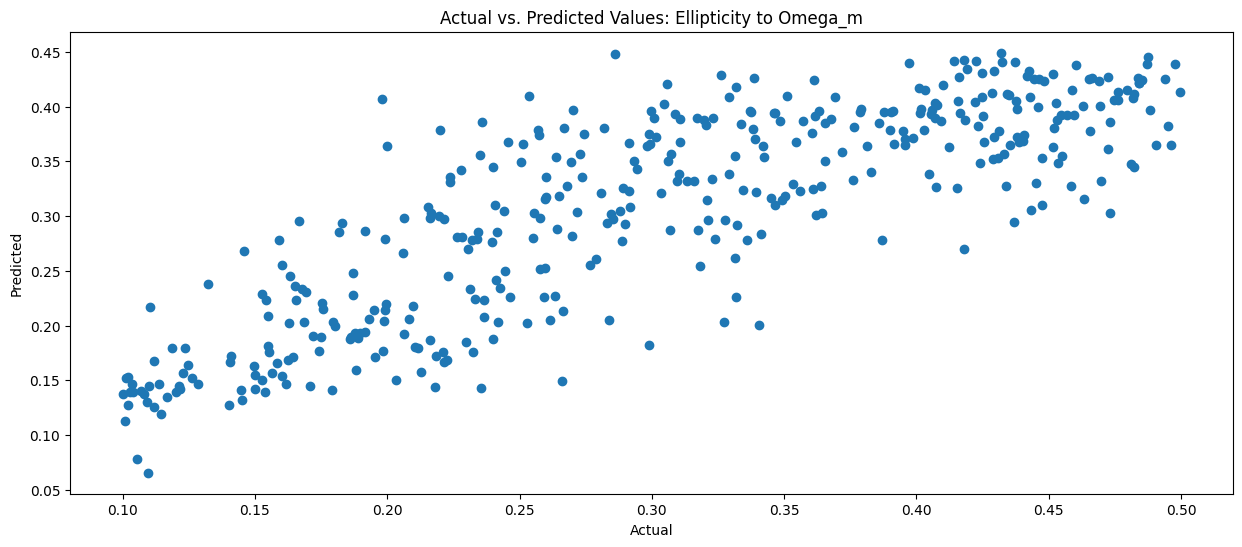

In [127]:
plt.figure(figsize=(15,6))

plt.scatter(om_test, predictions_om, zorder = 10)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values: Ellipticity to Omega_m')